In [3]:
import os
if os.name == 'nt':
    %env DOC=C:\Users\BK\Documents
else:
    %env DOC=/Users/muuzh/Documents

from AMI import automutual_info_single, automutual_info, automutual_info_k1

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import seaborn as sns
import pandas as pd
import time
import itertools
import scipy.stats as stats
import jpype
import datasets as datasets

env: DOC=C:\Users\BK\Documents


In [4]:
def poincare_plot(data, stride=1):
    """
    Create a Poincare plot from a time series.

    Parameters
    ----------
    data : array_like
        The time series data.
    stride : int, optional
        The stride between consecutive points in the time series. Default is 1.

    Returns
    -------
    tuple
        A tuple containing the x and y coordinates of the Poincare plot.
    """
    x = data[:-stride]
    y = data[stride:]
    return x, y

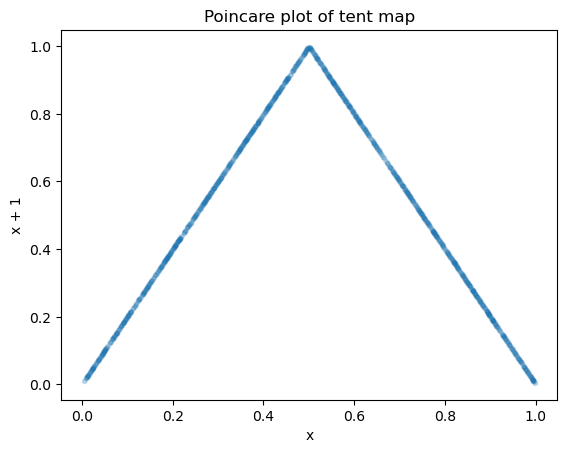

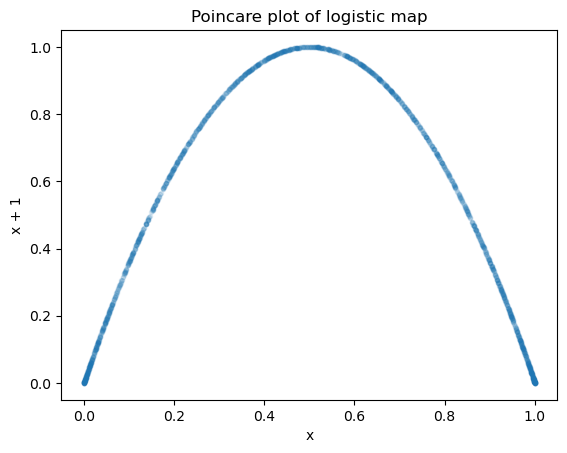

In [5]:
x_start = 0.1
series_length = 2200
tent_a_num = 400
tent_logistic_num = 400

param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
param_range_logistic = np.linspace(3.57, 4, tent_logistic_num)

tent_full_data = np.array([
    np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    for mu in param_range_tent
])
logistic_full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in param_range_logistic
])


# delete the first 200 points for each series
tent_full_data = tent_full_data[:, 200:]
logistic_full_data = logistic_full_data[:, 200:]

x, y = poincare_plot(tent_full_data[-1], stride=1)
plt.figure()
plt.scatter(x, y, marker='.',alpha=0.1)
plt.xlabel("x")
plt.ylabel("x + 1")
plt.title("Poincare plot of tent map")
plt.show()

x, y = poincare_plot(logistic_full_data[-1], stride=1)
plt.figure()
plt.scatter(x, y, marker='.',alpha=0.1)
plt.xlabel("x")
plt.ylabel("x + 1")
plt.title("Poincare plot of logistic map")
plt.show()

In [6]:
tentAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in tent_full_data
])
logisticAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logistic_full_data
])


tentAMI1_k2 = automutual_info(tent_full_data, 1, 3)
logisticAMI1_k2 = automutual_info(logistic_full_data, 1, 3)

tentAMI1_k1 = automutual_info_k1(tent_full_data, 1, 3)
logisticAMI1_k1 = automutual_info_k1(logistic_full_data, 1, 3)

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

In [7]:
tentLambdas = np.log(param_range_tent, where=param_range_tent > 0)
tentLambdas[np.where(param_range_tent <= 0)] = np.nan
tentChaoticIdx = np.where(tentLambdas > 0)

logisticLambdas =np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, param_range_logistic)
    ])
logisticChaoticIdx = np.where(logisticLambdas > 0)

tentParamRangeChaotic = param_range_tent[tentChaoticIdx]
tentAC1Chaotic = tentAC1[tentChaoticIdx]
tentAMI1Chaotic_k1 = tentAMI1_k1[tentChaoticIdx]
tentAMI1Chaotic_k2 = tentAMI1_k2[tentChaoticIdx]

logisticParamRangeChaotic = param_range_logistic[logisticChaoticIdx]
logisticAC1Chaotic = logisticAC1[logisticChaoticIdx]
logisticAMI1Chaotic_k1 = logisticAMI1_k1[logisticChaoticIdx]
logisticAMI1Chaotic_k2 = logisticAMI1_k2[logisticChaoticIdx]

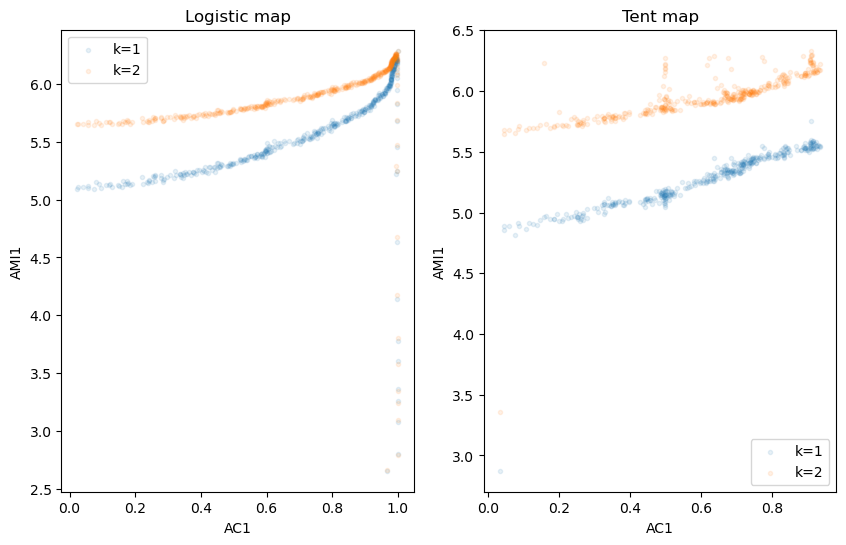

In [10]:
# plot AMI1 vs AC1 on the same figure, logistic map and tent map in different subplots
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title("Logistic map")
# use legends to distinguish different k
plt.scatter(np.abs(tentAC1Chaotic), tentAMI1Chaotic_k1, marker='.',alpha=0.1 ,label="k=1")
plt.scatter(np.abs(tentAC1Chaotic), tentAMI1Chaotic_k2, marker='.',alpha=0.1, label="k=2")
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.legend(loc="best")
plt.subplot(1, 2, 2)
plt.title("Tent map")
plt.scatter(np.abs(logisticAC1Chaotic), logisticAMI1Chaotic_k1, marker='.',alpha=0.1, label="k=1")
plt.scatter(np.abs(logisticAC1Chaotic), logisticAMI1Chaotic_k2, marker='.',alpha=0.1, label="k=2")
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.legend(loc="best")
plt.show()

In [27]:
# Define AMI_distance to be: For a random point in AC1 AMI1 space, compute AMI values for AR(1) series with parameter that equal to this AC1, 
# then number of stds away from the mean of AR(1) series is defined to be the distance
def AMI_for_AR1(AC1, sample_size=50):
    # genenerate AR(1) series with AC1, with sample_size points
    lag1para = AC1
    series_length = 2000
    ARpara = np.r_[1, -lag1para]
    AR1matrix = np.array([ArmaProcess(ARpara, [1]).generate_sample(series_length) for _ in trange(sample_size)])
    AR1AMI1 = automutual_info(AR1matrix, 1, 3)
    return AR1AMI1
def AMI_for_AR1_all_at_once(AC1s, sample_size=50):
    # genenerate AR(1) series with AC1, with sample_size points
    lag1para = AC1s
    series_length = 2000
    ARpara = [np.r_[1, -arparams] for arparams in AC1s]
    AR1matrix = np.full((len(AC1s), sample_size, series_length), np.nan)
    for i, ar in enumerate(tqdm(ARpara)):
        AR1matrix[i] = [ArmaProcess(ar, [1]).generate_sample(series_length) for _ in range(sample_size)]
    AR1AMI1 = automutual_info(AR1matrix, 1, 3)
    return AR1AMI1

In [28]:
# compute corresponding AMI values for tent map and logistic map
tentAMI1_AR1 = AMI_for_AR1_all_at_once(tentAC1Chaotic, sample_size=20)


  0%|          | 0/400 [00:00<?, ?it/s]

Processing:   0%|          | 0/8000 [00:00<?, ?it/s]

In [34]:
print(len(tentAC1Chaotic))
print(tentAMI1_AR1.shape)


400
(400, 20)


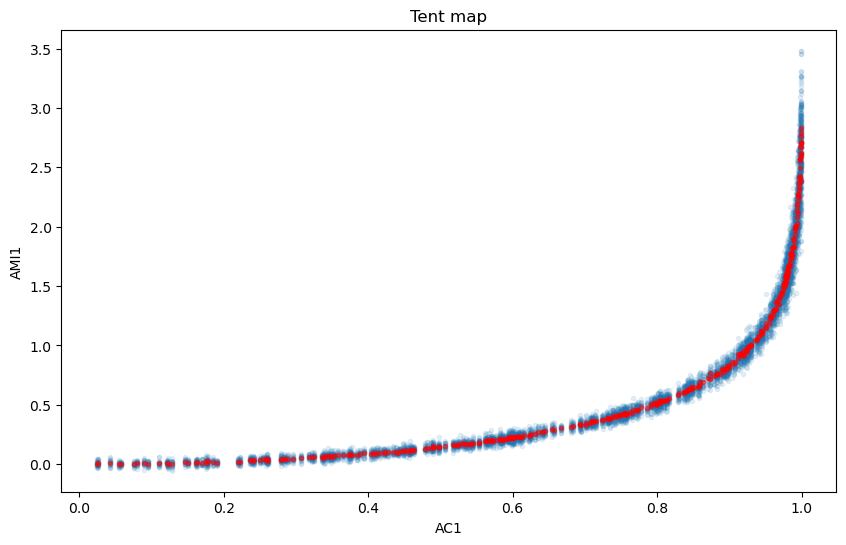

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(np.repeat(np.abs(tentAC1Chaotic), 20), tentAMI1_AR1, marker='.',alpha=0.1)

plt.scatter(np.abs(tentAC1Chaotic), tentAMI1_AR1.mean(axis=1), color="red", marker='.',alpha=0.5)
# scatter mean with std 
# plt.errorbar(np.abs(tentAC1Chaotic), tentAMI1_AR1.mean(axis=1), yerr=tentAMI1_AR1.std(axis=1), color="red", marker='.',alpha=0.5)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("Tent map")
plt.show()


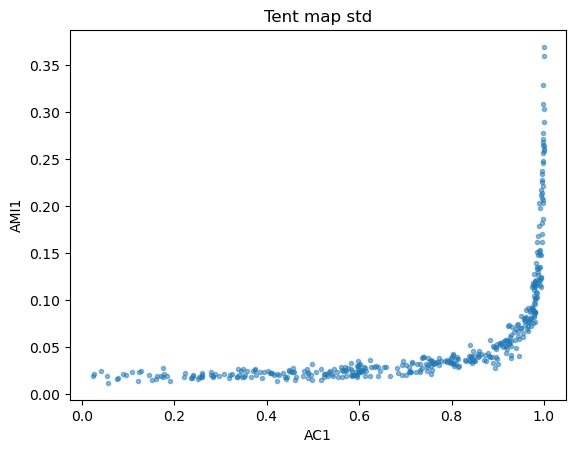

In [47]:
plt.scatter(np.abs(tentAC1Chaotic), tentAMI1_AR1.std(axis=1), marker='.',alpha=0.5)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("Tent map std")

plt.show()

In [61]:

tent_AMI_distance = (np.array(tentAMI1Chaotic_k2) - np.array(np.flip(tentAMI1_AR1.mean(axis=1))))/np.array(np.flip(tentAMI1_AR1.std(axis=1)))

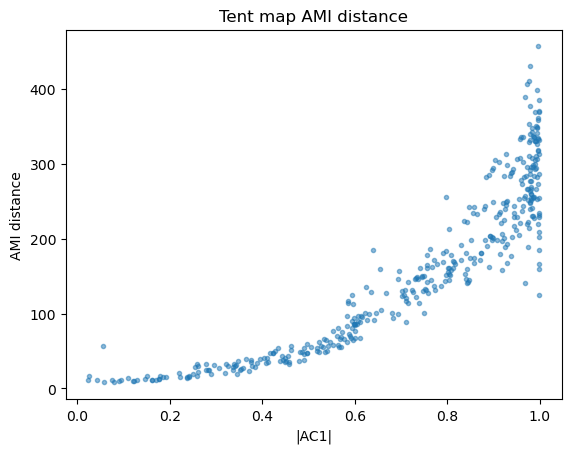

In [65]:
plt.scatter(np.abs(tentAC1Chaotic), AMI_distance, marker='.',alpha=0.5)
plt.xlabel("|AC1|")
plt.ylabel("AMI distance")
plt.title("Tent map AMI distance")
plt.show()

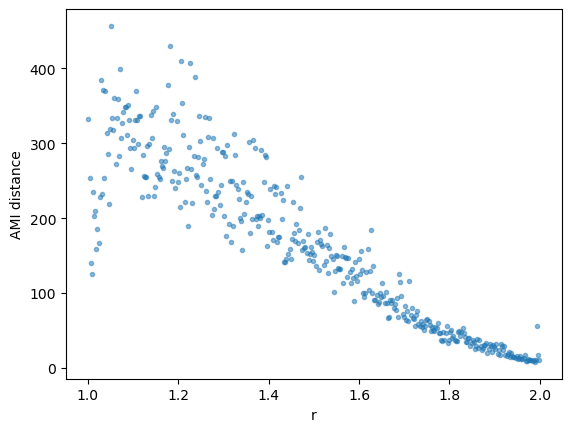

In [66]:
tent_chaotic_range = param_range_tent[tentChaoticIdx]
plt.scatter(tent_chaotic_range, AMI_distance, marker='.',alpha=0.5)
plt.xlabel("r")
plt.ylabel("AMI distance")

plt.show()

In [186]:
# tentAMI1_AR1 = AMI_for_AR1_all_at_once(tentAC1Chaotic, sample_size=20)
logisticAMI1_AR1 = AMI_for_AR1_all_at_once(logisticAC1Chaotic, sample_size=20)

  0%|          | 0/364 [00:00<?, ?it/s]

Processing:   0%|          | 0/7280 [00:00<?, ?it/s]

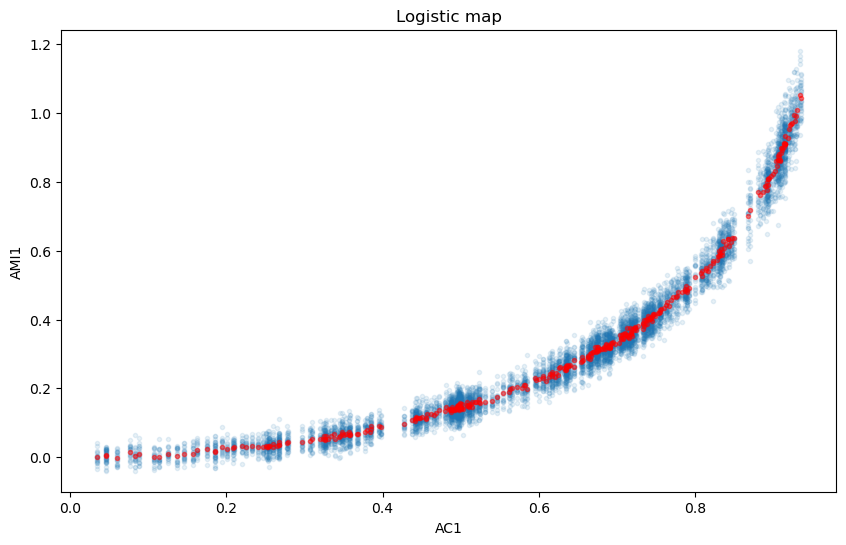

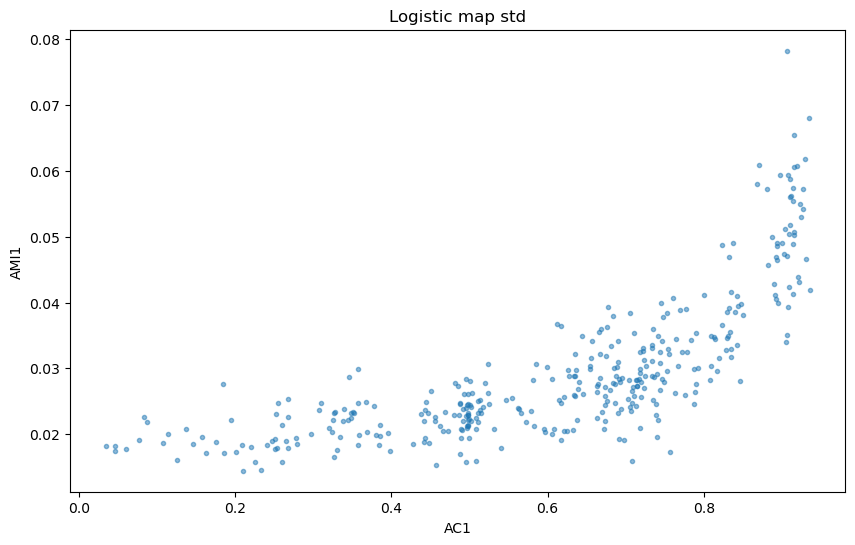

In [188]:
plt.figure(figsize=(10, 6))
plt.scatter(np.repeat(np.abs(logisticAC1Chaotic), 20), logisticAMI1_AR1, marker='.',alpha=0.1)

plt.scatter(np.abs(logisticAC1Chaotic), logisticAMI1_AR1.mean(axis=1), color="red", marker='.',alpha=0.5)
# scatter mean with std 
# plt.errorbar(np.abs(tentAC1Chaotic), tentAMI1_AR1.mean(axis=1), yerr=tentAMI1_AR1.std(axis=1), color="red", marker='.',alpha=0.5)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("Logistic map")
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(np.abs(logisticAC1Chaotic), logisticAMI1_AR1.std(axis=1), marker='.',alpha=0.5)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("Logistic map std")

plt.show()

In [190]:
logistic_AMI_distance = (np.array(logisticAMI1Chaotic_k2) - np.array((logisticAMI1_AR1.mean(axis=1))))/np.array((logisticAMI1_AR1.std(axis=1)))

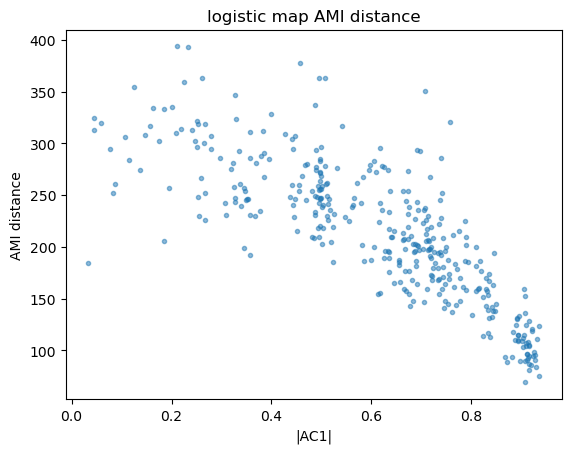

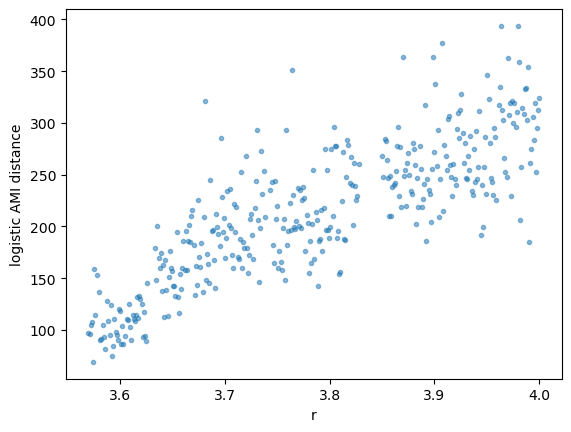

In [192]:
plt.scatter(np.abs(logisticAC1Chaotic), logistic_AMI_distance, marker='.',alpha=0.5)
plt.xlabel("|AC1|")
plt.ylabel("AMI distance")
plt.title("logistic map AMI distance")
plt.show()

logistic_chaotic_range = param_range_logistic[logisticChaoticIdx]
plt.scatter(logistic_chaotic_range, logistic_AMI_distance, marker='.',alpha=0.5)
plt.xlabel("r")
plt.ylabel("logistic AMI distance")

plt.show()

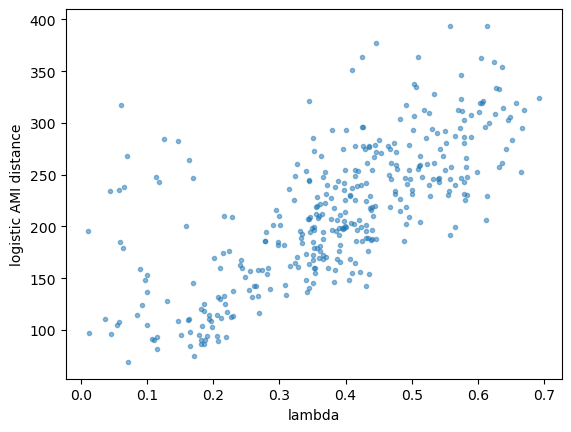

In [193]:
logisticLambdasChaotic = logisticLambdas[logisticChaoticIdx]
plt.scatter(logisticLambdasChaotic, logistic_AMI_distance, marker='.',alpha=0.5)
plt.xlabel("lambda")
plt.ylabel("logistic AMI distance")
plt.show()